In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
import numpy as np
attrs_scaled = np.load("X.npy")

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [ ]:
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

**Модель 1 (глубокий)**

In [ ]:
x_train, x_test = train_test_split(attrs_scaled, test_size = 0.15, random_state=32, shuffle = True)

In [ ]:
def deep_ae(dim1, dim2, weigts_init, bias_init):
    encoding_dim = 10 # судя по дисперсиям 90% инфы дают 10 компонент (см. PCA)
    
    input_attrs = Input(shape = (20,))
    x = Dense(dim1, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(input_attrs)
    x = Dense(dim2, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(x)
    code = Dense(encoding_dim, activation='linear')(x)
    
    input_code = Input(shape = (encoding_dim,))
    x = Dense(dim2, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(input_code)
    x = Dense(dim1, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(x)
    out_attrs = Dense(20, activation='linear')(x)

    encoder = Model(input_attrs, code, name="encoder")
    decoder = Model(input_code, out_attrs, name="decoder")
    autoencoder = Model(input_attrs, decoder(encoder(input_attrs)), name="autoencoder")

    return autoencoder

In [ ]:
# гиперпараметры
DIM_1L = 19
DIM_2L = 17
WEIGTHS_INIT = 'random_uniform' 
BIAS_INIT = 'zeros'
LERN_RATE = 0.0005
LOSS = 'mse'
OPTI = globals()['Adam']
BATCH = 70

In [ ]:
d_ae = deep_ae(DIM_1L, DIM_2L, WEIGTHS_INIT, BIAS_INIT)

d_ae.compile(OPTI(LERN_RATE), loss=LOSS, metrics=['mae'])

In [ ]:
callbacks = [
        ModelCheckpoint(
        filepath='/content/drive/My Drive/Colab Notebooks/keras_checkpoint/model1/ae_epoch={epoch}_loss={val_loss:.5f}_metr={val_mae}.h5', # путь по которому нужно сохранить модель
        # два параметра ниже значат, что мы перезапишем
        # текущий чекпоинт в том и только в том случае, когда
        # улучится значение val_loss
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
            ]

In [ ]:
 # stop training when a monitored quantity has stopped improving
 # patience - сколько эпох терпеть не улучшения качества (здесь не уменьшения val_loss)
 # restore_best_weights=True - сохранятся веса с лучшим качеством (здесь с минимальным val_loss)
 earlyStopping = EarlyStopping(monitor='val_loss', patience=200, verbose=1, restore_best_weights=True)
 callbacks = [earlyStopping]

In [ ]:
d_ae.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 20)                0         
_________________________________________________________________
encoder (Model)              (None, 10)                919       
_________________________________________________________________
decoder (Model)              (None, 20)                909       
Total params: 1,828
Trainable params: 1,828
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epo = 3000 # возможно можно > 2000

hist = d_ae.fit(x_train, # shape[0] у подаваемых объектов должен быть их числом
                x_train, 
                epochs=epo, # в конце каждой эпохи проводится мониторинг функции потерь (val_loss) на validation_data (эпоха - отработать все объекты (случайно выбирается в течение эпохи количество объектов = количеству объектов в тренировочной выборке))
                batch_size=BATCH, # сколько объектов будет накоплено (в сумму функционала ошибки) для одного обновления градиента (по умолчанию 32)
                shuffle=True, # перемешивать ли тренировочные данные в конце каждой эпохи
                verbose=1, # показ progress bar
                validation_data=(x_test, x_test), # данные для контроля переобучения
                callbacks = callbacks)

Streaming output truncated to the last 5000 lines.
14518/14518 [==============================] - 0s 21us/step - loss: 0.0509 - mae: 0.0925 - val_loss: 0.0383 - val_mae: 0.1010
Epoch 391/3000
14518/14518 [==============================] - 0s 21us/step - loss: 0.0518 - mae: 0.0950 - val_loss: 0.0360 - val_mae: 0.0932
Epoch 392/3000
14518/14518 [==============================] - 0s 21us/step - loss: 0.0508 - mae: 0.0929 - val_loss: 0.0359 - val_mae: 0.0948
Epoch 393/3000
14518/14518 [==============================] - 0s 21us/step - loss: 0.0508 - mae: 0.0932 - val_loss: 0.0353 - val_mae: 0.0935
Epoch 394/3000
14518/14518 [==============================] - 0s 21us/step - loss: 0.0505 - mae: 0.0931 - val_loss: 0.0369 - val_mae: 0.0970
Epoch 395/3000
14518/14518 [==============================] - 0s 21us/step - loss: 0.0509 - mae: 0.0933 - val_loss: 0.0355 - val_mae: 0.0937
Epoch 396/3000
14518/14518 [==============================] - 0s 22us/step - loss: 0.0506 - mae: 0.0930 - val_loss: 0.

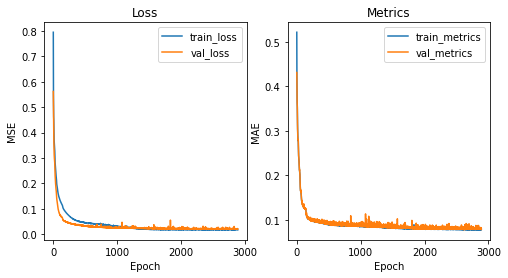

<Figure size 432x288 with 0 Axes>

In [ ]:
N = np.arange(0, len(hist.history["loss"]))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

ax1.plot(N, hist.history["loss"], label="train_loss")
ax1.plot(N, hist.history["val_loss"], label="val_loss")

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE")
ax1.legend()

fig = plt.figure()
ax2.plot(N, hist.history["mae"], label="train_metrics")
ax2.plot(N, hist.history["val_mae"], label="val_metrics")

ax2.set_title("Metrics")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("MAE")
ax2.legend()

plt.show()

In [ ]:
d_ae.evaluate(x_test, x_test) # показывает loss и metrics на подаваемых данных

2562/2562 [==============================] - 0s 20us/step


[0.02014360539062613, 0.07831672579050064]

**Модель 1 (глубокий) (cross validation)**



In [ ]:
def deep_ae(dim1, dim2, weigts_init, bias_init):
    encoding_dim = 10 # судя по дисперсиям 90% инфы дают 10 компонент (см. PCA)
    
    input_attrs = Input(shape = (20,))
    x = Dense(dim1, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(input_attrs)
    x = Dense(dim2, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(x)
    code = Dense(encoding_dim, activation='linear')(x)
    
    input_code = Input(shape = (encoding_dim,))
    x = Dense(dim2, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(input_code)
    x = Dense(dim1, activation='tanh', bias_initializer=bias_init, kernel_initializer=weigts_init)(x)
    out_attrs = Dense(20, activation='linear')(x)

    encoder = Model(input_attrs, code, name="encoder")
    decoder = Model(input_code, out_attrs, name="decoder")
    autoencoder = Model(input_attrs, decoder(encoder(input_attrs)), name="autoencoder")

    return autoencoder

In [ ]:
# гиперпараметры
DIM_1L = 19
DIM_2L = 17
WEIGTHS_INIT = 'random_uniform'
BIAS_INIT = 'zeros'
LERN_RATE = 0.0005
LOSS = 'mse'
OPTI = globals()['Adam']
BATCH = 70

In [ ]:
epo = 1000
hists = []
folds = 10

kf = KFold(n_splits = folds, shuffle = True)

num_fold = 1
for train, test in kf.split(attrs_scaled, attrs_scaled):

  d_ae = deep_ae(DIM_1L, DIM_2L, WEIGTHS_INIT, BIAS_INIT)

  d_ae.compile(OPTI(LERN_RATE), loss=LOSS, metrics=['mae'])

  print("Number of fold {} ======================================================".format(num_fold))

  hist = d_ae.fit(attrs_scaled[train], # shape[0] у подаваемых объектов должен быть их числом
                  attrs_scaled[train], 
                  epochs=epo, # в конце каждой эпохи проводится мониторинг функции потерь (val_loss) на validation_data (эпоха - отработать все объекты (случайно выбирается в течение эпохи количество объектов = количеству объектов в тренировочной выборке))
                  batch_size=BATCH, # сколько объектов будет накоплено (в сумму функционала ошибки) для одного обновления градиента (по умолчанию 32)
                  shuffle=True, # перемешивать ли тренировочные данные в конце каждой эпохи
                  verbose=2, # показ progress bar
                  validation_data=(attrs_scaled[test], attrs_scaled[test])) # данные для контроля переобучения
  
  d_ae.save_weights('/content/drive/My Drive/Colab Notebooks/keras_checkpoint/model1_cross_val/d_ae_fold{}.h5'.format(num_fold))

  hists.append(hist)
  num_fold += 1

Fold 1


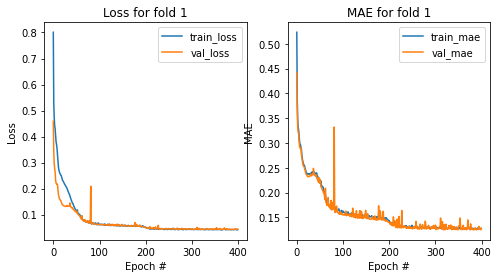

<Figure size 432x288 with 0 Axes>

Fold 2


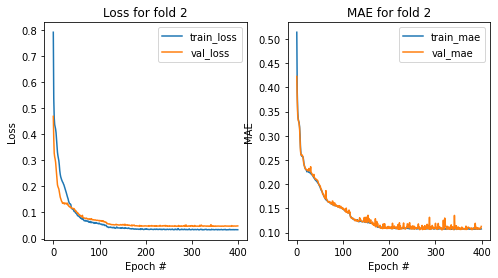

<Figure size 432x288 with 0 Axes>

Fold 3


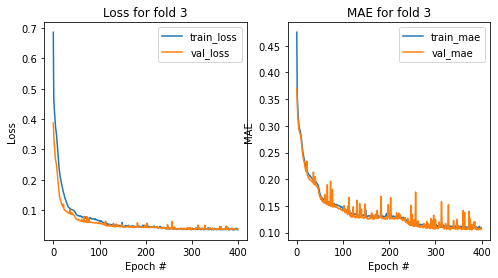

<Figure size 432x288 with 0 Axes>

Fold 4


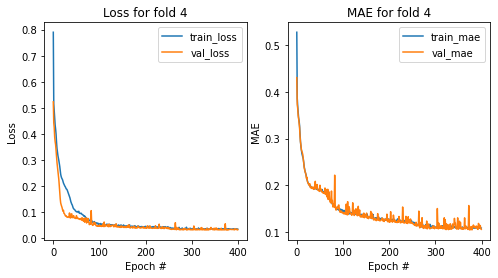

<Figure size 432x288 with 0 Axes>

Fold 5


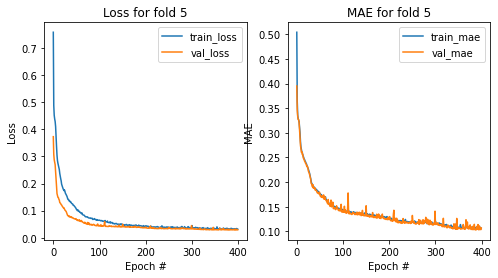

<Figure size 432x288 with 0 Axes>

Fold 6


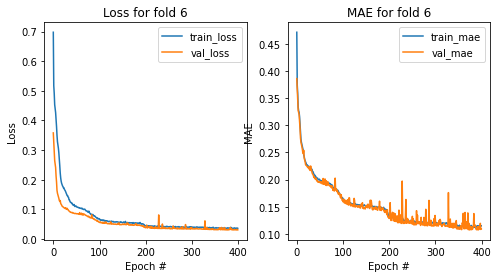

<Figure size 432x288 with 0 Axes>

Fold 7


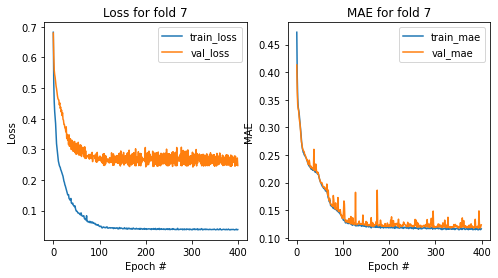

<Figure size 432x288 with 0 Axes>

Fold 8


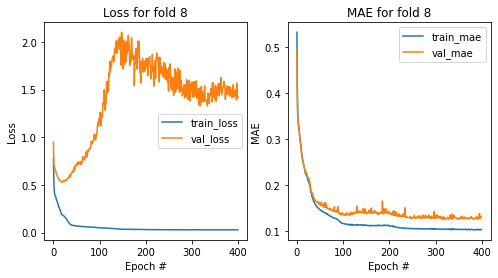

<Figure size 432x288 with 0 Axes>

Fold 9


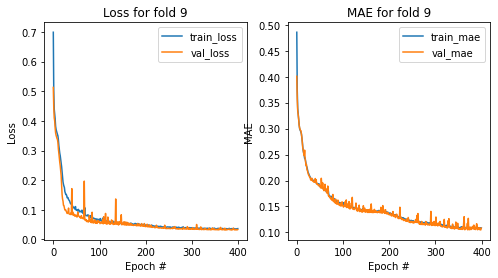

<Figure size 432x288 with 0 Axes>

In [ ]:
N = np.arange(0, epo)
for i in range(1, folds):
  print("Fold {}".format(i))
  
  fig, (ax1, ax2) = plt.subplots(
  nrows=1, ncols=2,
  figsize=(8, 4) )

  ax1.plot(N, hists[i-1].history["loss"], label="train_loss")
  ax1.plot(N, hists[i-1].history["val_loss"], label="val_loss")

  ax1.set_title("Loss for fold {}".format(i))
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("MSE")
  ax1.legend()

  fig = plt.figure()
  ax2.plot(N, hists[i-1].history["mae"], label="train_metrics")
  ax2.plot(N, hists[i-1].history["val_mae"], label="val_metrics")

  ax2.set_title("Metrics for fold {}".format(i))
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("MAE")
  ax2.legend()

  plt.show()

In [ ]:
for i in range(1, folds):
  print("Fold ", i, " Train_Loss ", hists[i-1].history["loss"][-1], " Val_Loss ", hists[i-1].history["val_loss"][-1], " Train_mae ", hists[i-1].history["mae"][-1], " Val_mae ", hists[i-1].history["val_mae"][-1])

Fold  1  Train_Loss  0.04224586653997697  Val_Loss  0.04381725244775079  Train_mae  0.12791388  Val_mae  0.12790967524051666
Fold  2  Train_Loss  0.03382052660034746  Val_Loss  0.0483381626558553  Train_mae  0.10745655  Val_mae  0.11268948018550873
Fold  3  Train_Loss  0.03517038042158792  Val_Loss  0.03871844455053217  Train_mae  0.108468436  Val_mae  0.10979031771421432
Fold  4  Train_Loss  0.03520402222209175  Val_Loss  0.03279479767796386  Train_mae  0.108708  Val_mae  0.10608036071062088
Fold  5  Train_Loss  0.0312966556570069  Val_Loss  0.029313006326843874  Train_mae  0.105992645  Val_mae  0.10686755180358887
Fold  6  Train_Loss  0.03594014972681646  Val_Loss  0.030546697859857305  Train_mae  0.11477126  Val_mae  0.10887704789638519
Fold  7  Train_Loss  0.03801535080968141  Val_Loss  0.2471724358462804  Train_mae  0.11641559  Val_mae  0.12362018972635269
Fold  8  Train_Loss  0.02978768237433158  Val_Loss  1.4232958337601318  Train_mae  0.103861436  Val_mae  0.13225498795509338
F

**Модель 1 (глубокий) (гиперпараметры)**

In [ ]:
def deep_ae(dim1, dim2, act, weigts_init, bias_init, opt, l_rate, ls):
    encoding_dim = 10 # судя по дисперсиям 90% инфы дают 10 компонент (см. PCA)
    
    input_attrs = Input(shape = (20,))
    x = Dense(dim1, activation=act, bias_initializer=bias_init, kernel_initializer=weigts_init)(input_attrs)
    x = Dense(dim2, activation=act, bias_initializer=bias_init, kernel_initializer=weigts_init)(x)
    code = Dense(encoding_dim, activation='linear')(x)
    
    input_code = Input(shape = (encoding_dim,))
    x = Dense(dim2, activation=act, bias_initializer=bias_init, kernel_initializer=weigts_init)(input_code)
    x = Dense(dim1, activation=act, bias_initializer=bias_init, kernel_initializer=weigts_init)(x)
    out_attrs = Dense(20, activation='linear')(x)

    encoder = Model(input_attrs, code, name="encoder")
    decoder = Model(input_code, out_attrs, name="decoder")
    autoencoder = Model(input_attrs, decoder(encoder(input_attrs)), name="autoencoder")

    autoencoder.compile(opt(l_rate), loss=ls)

    return autoencoder

In [ ]:
 # stop training when a monitored quantity has stopped improving
 # patience - сколько эпох терпеть не улучшения качества (здесь не уменьшения val_loss)
 # restore_best_weights=True - сохранятся веса с лучшим качеством (здесь с минимальным val_loss)
 # обычно добавляется как callback в model.fit, но мы используем scikit-learn API; чтобы не было проблем, надо добавить earlyStopping в GridSearchCV_object.fit, причём как-то хитро (см. ниже)
 earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

In [ ]:
# как и KerasClassifier позволяет использовать модели из keras в методах scikit-learn
# почему-то не работает
#model = KerasRegressor(build_fn = deep_ae, epochs = 300, verbose=1, dim2=14, act='sigmoid', weigts_init='random_uniform', bias_init='zeros', opt=globals()['Adam'], batch_size=30, callbacks=[earlyStopping])
model = KerasRegressor(build_fn = deep_ae, epochs = 300, verbose=1, dim1=19, dim2=17, act='tanh', weigts_init='random_uniform', bias_init='zeros', ls='mse', opt=globals()['Adam'])

In [ ]:
param_grid = dict(batch_size=[50, 30, 70], l_rate=[0.001, 0.0001, 0.0005])
#param_grid = dict(dim1=[19, 17], dim2=[16, 14], act=['sigmoid', 'elu'], l_rate=[0.0005, 0.005, 0.05], ls=['mse', 'bce'])
#param_grid = dict(dim1=[19, 18, 17], dim2=[16, 15, 14], act=['sigmoid', 'tanh', 'elu'], weigts_init=['random_uniform', 'zeros'], l_rate=[0.0005, 0.005, 0.05], ls=['mse', 'bce'])
#param_grid = dict(dim1=[19, 18, 17], dim2=[16, 15, 14], weigts_init=['random_uniform', 'zeros'], bias_init=['zeros'], opt=[globals()['Adam']], l_rate=[0.0005, 0.005, 0.05], ls=['mse', 'bce'], batch=[30, 70])
#param_grid = dict(dim1=[19, 18], dim2=[14], weigts_init=['random_uniform'], bias_init=['zeros'], opt=[globals()['Adam']], l_rate=[0.005], ls=['mse'], batch_size=[50])

In [ ]:
fit_params={'callbacks':[earlyStopping]}

In [ ]:
# n_jobs=-1 - будет использовать все ядра; cv=3 - cross validation для каждой модели (число разбиений)
# видимо это работает так: сначала тренируется модель в рамках keras, затем она измеряется на тестовых данных (если есть cv, то метод GridSearchCV делает cross validation)
# метрика, в которой измеряется конкретная модель подаётся через scoring в GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=0, scoring='neg_mean_absolute_error') # neg_mean_absolute_error есть mae

# почему-то не работает
#grid_result = grid.fit(attrs_scaled, attrs_scaled, fit_params={'callbacks':[earlyStopping]})
grid_result = grid.fit(attrs_scaled, attrs_scaled, **fit_params)

Epoch 1/300
17080/17080 [==============================] - 0s 27us/step - loss: 0.8069
Epoch 2/300
 8680/17080 [==============>...............] - ETA: 0s - loss: 0.4782

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


17080/17080 [==============================] - 0s 19us/step - loss: 0.5846
Epoch 3/300
17080/17080 [==============================] - 0s 18us/step - loss: 0.5649
Epoch 4/300
17080/17080 [==============================] - 0s 18us/step - loss: 0.5487
Epoch 5/300
17080/17080 [==============================] - 0s 18us/step - loss: 0.4906
Epoch 6/300
17080/17080 [==============================] - 0s 18us/step - loss: 0.4425
Epoch 7/300
17080/17080 [==============================] - 0s 18us/step - loss: 0.4207
Epoch 8/300
17080/17080 [==============================] - 0s 18us/step - loss: 0.4082
Epoch 9/300
17080/17080 [==============================] - 0s 19us/step - loss: 0.4012
Epoch 10/300
17080/17080 [==============================] - 0s 19us/step - loss: 0.3960
Epoch 11/300
17080/17080 [==============================] - 0s 17us/step - loss: 0.3920
Epoch 12/300
17080/17080 [==============================] - 0s 18us/step - loss: 0.3875
Epoch 13/300
17080/17080 [==========================

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.176068 using {'batch_size': 70, 'l_rate': 0.0005}
-0.180477 (0.082005) with: {'batch_size': 50, 'l_rate': 0.001}
-0.296313 (0.085494) with: {'batch_size': 50, 'l_rate': 0.0001}
-0.208164 (0.100467) with: {'batch_size': 50, 'l_rate': 0.0005}
-0.208100 (0.105902) with: {'batch_size': 30, 'l_rate': 0.001}
-0.269945 (0.073897) with: {'batch_size': 30, 'l_rate': 0.0001}
-0.188083 (0.081228) with: {'batch_size': 30, 'l_rate': 0.0005}
-0.184744 (0.084326) with: {'batch_size': 70, 'l_rate': 0.001}
-0.289900 (0.049397) with: {'batch_size': 70, 'l_rate': 0.0001}
-0.176068 (0.078683) with: {'batch_size': 70, 'l_rate': 0.0005}


In [ ]:
grid_result.best_estimator_

In [ ]:
# гиперпараметры
DIM_1L = 18
DIM_2L = 14
WEIGTHS_INIT = 'random_uniform' # 'zeros', 'lecun_uniform', 
BIAS_INIT = 'zeros' # 'random_uniform', 'lecun_uniform',
LERN_RATE = 0.0005 # 0.00005, 0.005, 0.05, 0.5
LOSS = 'mse' # 'bce'
OPTI = globals()['Adam'] # 'Adadelta', 'Adagrad', 'Adamax', 'Ftrl', 'Nadam', 'RMSprop', 'SGD'
BATCH = 30

epo = 400

In [ ]:
# d_ae = deep_ae(DIM_1L, DIM_2L, WEIGTHS_INIT, BIAS_INIT)

d_ae.compile(OPTI(LERN_RATE), loss=LOSS, metrics=['mae'])

In [ ]:
callbacks = [
        ModelCheckpoint(
        filepath='/content/drive/My Drive/Colab Notebooks/keras_checkpoint/model1/ae_epoch={epoch}_loss={val_loss:.5f}_metr={val_mae}.h5', # путь по которому нужно сохранить модель
        # два параметра ниже значат, что мы перезапишем
        # текущий чекпоинт в том и только в том случае, когда
        # улучится значение val_loss
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
            ]

In [ ]:
d_ae.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        (None, 20)                0         
_________________________________________________________________
encoder (Model)              (None, 10)                794       
_________________________________________________________________
decoder (Model)              (None, 20)                764       
Total params: 1,558
Trainable params: 1,558
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = d_ae.fit(attrs_scaled[train], # shape[0] у подаваемых объектов должен быть их числом
                attrs_scaled[train], 
                epochs=epo, # в конце каждой эпохи проводится мониторинг функции потерь (val_loss) на validation_data (эпоха - отработать все объекты (случайно выбирается в течение эпохи количество объектов = количеству объектов в тренировочной выборке))
                batch_size=BATCH, # сколько объектов будет накоплено (в сумму функционала ошибки) для одного обновления градиента (по умолчанию 32)
                shuffle=True, # перемешивать ли тренировочные данные в конце каждой эпохи
                verbose=1, # показ progress bar
                validation_data=(attrs_scaled[test], attrs_scaled[test]), # данные для контроля переобучения
                callbacks = callbacks)

In [ ]:
N = np.arange(0, epo)
fig = plt.figure()
plt.plot(N, hist.history["loss"], label="train_loss")
plt.plot(N, hist.history["val_loss"], label="val_loss")

plt.title("Loss")
plt.xlabel("Epoch #")
#plt.xlim(0,15)
plt.ylabel("Loss")
plt.legend()

In [ ]:
fig = plt.figure()
plt.plot(N, hist.history["mae"], label="train_acc")
plt.plot(N, hist.history["val_mae"], label="val_acc")

plt.title("MAE")
plt.xlabel("Epoch #")
plt.ylabel("MAE")
plt.legend()

In [ ]:
from sklearn.base import ClassifierMixin, BaseEstimator

class CNN_model(ClassifierMixin, BaseEstimator) :
      def __init__(**model_params) :
          """
              define model parameters within this init function
          """
          self.model = # Use the params above and make a keras model and store it in this variable
          self.model.compile(loss=  , optimizer =   , metrics=[]) # Please fill-in the appropriate loss and metrics

       def fit(X,y) :
          self.model.fit(X,y, training_params)
          # You specify everything in training_params e.g. epoch, callbacks(which includes early stopping)
          return self

       def predict(X) :
          return self.model.predict(X)